CARO

# 2) 

## c) 
Armamos un código para generar una red aleatoria tipo Barabasi, con $n$ cantidad de nodos y un grado inicial $k_0$ fijo e igual para cada nodo. 
Este tipo de red consiste en comenzar con pocos nodos de grado $k_0$ e ir agregando un nodo de grado $k_0$ en cada paso. Los nodos ya agregados irán aumentando su grado al conectarse con los nodos nuevos que se vayan agregando. La manera de conectar un nodo nuevo a los existentes es aleatoria, determinada por una probabilidad proporcional al grado de cada nodo existente. Es decir, la probabilidad de que el nodo nuevo se enlace a uno existente (i) es: $P = \frac{k_i}{\sum{j}k_j}$. Donde la sumatoria es sobre todos los nodos existentes. Para lo mismo, utilizamos una función de Numpy.Random.choice que elije de una lista con una dada probabilidad para cada elemento. 


In [11]:
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np

In [12]:
import numpy as np
def barabasi(k_0, final_nodes):
    #m es el grado de los nodos iniciales y a la vez la cantidad de enlaces que agrego por iteracion
    
    new_node = k_0
        
    G = nx.complete_graph(k_0) #primero un grafo completo
    G_dict = {key: k_0-1 for key in range(k_0)} #usamos un dict para no recorrer siempre la red 
    
    for step in range(final_nodes - k_0):
        nodes_to_add = add_edges(G_dict, k_0)      
        G.add_node(new_node)
        G_dict[new_node] = k_0
        
        for node in nodes_to_add:
            G.add_edge(new_node, node)
            G_dict[node] += 1
                    
        new_node += 1
        
    return G

        
def add_edges(G_dict, k_0):
    nodes_probs = []
    nodes = list(G_dict.keys())
    total_degree = sum(G_dict.values())
    
    for node in nodes:
        node_degr = G_dict[node]
        node_prob = node_degr / total_degree if total_degree > 0 else 1/len(nodes) #probabilidad definida en el enunciado, puede elegir dos veces el mismo
        nodes_probs.append(node_prob)
        
    random_nodes = np.random.choice(nodes, size = k_0, p = nodes_probs, replace = False)
             
    return random_nodes

Armamos redes con $n = 10000$ y comprobamos que cumple la relación: $ enlaces \cong k_0 n$
Para lo mismo generamos 10 redes con $k_0$ aleatorios dentro de un rango (la idea de estos grafos es empezar con número 'pequeño' de nodos). En este caso el rango era de $0$ a $50$ que es, a lo sumo, un $0.5 \%$ del total de nodos $n$.

Creamos un diccionario que para cada red nos guarda su $k_0$, la diferencia entre los enlaces y el valor teórico y el porcentaje que eso representa del total. 

In [13]:
import networkx as nx
m_dict = {}
n = 10000
times = 1

for _ in range(times):
    k_0 = np.random.randint(0,50)
    Network = barabasi(k_0, n)
    num_edges = Network.number_of_edges()
    diff = abs(num_edges - k_0 * n)
    diff_percent = diff / num_edges * 100
    m_dict[k_0] = num_edges , diff, diff_percent

print(m_dict)

{45: (448965, 1035, 0.2305302195048612)}


In [14]:
mean = np.round(np.array([m_dict[k][2] for k in m_dict]).mean(), 2)
std = np.round(np.array([m_dict[k][2] for k in m_dict]).std(),2)

print(f' El porcentaje que representa la diferencia de enlaces presentes y el valor teórico es, para {times} redes: \n ({mean} + {std})%')

 El porcentaje que representa la diferencia de enlaces presentes y el valor teórico es, para 1 redes: 
 (0.23 + 0.0)%


Graficamos los valores esperados y el número de enlaces de cada red en función de su $k_0$. Podemos ver que la relación se cumple ya que cada nodo agregado ($n - k_0$) por paso crea $k_0$ enlaces nuevos a los $\frac{n (n-1)}{2}$ originales de un grafo completo (de entrada tenemos $k_0$  menos enlaces de lo predicho por la teoría.


Por como está definida random.choice puede elegir varias veces el mismo nodo, con lo cual hay nuevos nodos que generan menos de $k_0$ enlaces. Para cambiar esto, se usa la opción "replace = False" que asegura no estar sacando dos veces el mismo. De no ser así, tanto esa diferencia como los $k_0$ iniciales contribuirían a la diferencia calculada anteriormente. 


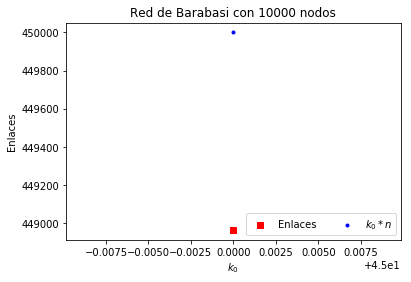

In [15]:
import matplotlib.pyplot as plt #esto se va cuando corramos todo

fig, ax = plt.subplots()
plt.xlabel('$k_0$')
plt.ylabel('Enlaces')
plt.title(f'Red de Barabasi con {n} nodos')

for key in m_dict.keys():
    
    scatter1 = ax.scatter(key, m_dict[key][0], c = 'r', alpha = 1, marker = 's')
    scatter2 = ax.scatter(key, key * n, c = 'b', alpha = 1, marker = '.')

ax.legend((scatter1, scatter2),
           ('Enlaces', '$k_0 * n$'),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=10)

plt.show()   

In [16]:
"Creo funcion que acepte n y m como parametros para realizar una Red Barabasi"
def Red_barabasi(n, m):
    k_0 = int(m / n)
    red = barabasi(k_0, n)
    return red
    

# 2 d

## d)
Calcule y grafique la distribución de grado para los 3 tipos de redes, para 4 casos donde m y n sean similares a aquellos de las redes del ejercicio 1). 
¿Qué tipo de red da una distribución más parecida a las de los datos? ¿Es posible extraer una conclusión general
sobre el mecanismo de generación de estas redes?

In [17]:
#importamos las librerías generales a utilizar
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


#creamos función para abrir .txt
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data

In [6]:
redes = {'Y2H': './data/yeast_Y2H.txt', 
         'Sistema Electrico': './data/power_enlaces.txt',
         'Papers': './data/netscience.gml',
         'Internet': './data/as-22july06.gml'
         }


def info_red(red):
    nombre, extension = os.path.splitext(red)
    if extension != '.txt':
        Red = nx.read_gml('./data/as-22july06.gml')
    else:
        lista_de_enlaces = abrir_txt(red)
        Red = nx.Graph()
        Red.add_edges_from(lista_de_enlaces)
    Grafo = Red
    Grados = Red.degree()
    return Grafo,Grados

def distribucion_grado_normal(lista_grados):
    
    hist,binedges = np.histogram(lista_grados,density=True,bins=max(lista_grados))
    bincenters = np.round(np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0))
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]
    
def cumulative_binning(lista_grados):
    lista_grados= np.flip(np.sort((lista_grados)))
    ranking = np.arange(1,len(lista_grados)+1)
    pk = ranking/len(ranking)                  
    return lista_grados,pk
    

In [7]:
Grafo_dict = {}
for red in redes:
    grafo, _ = info_red(redes[red])
    Grafo_dict[red] = {}
    Grafo_dict[red]["Grafo"] = grafo
    Grafo_dict[red]["Nodos"] = grafo.number_of_nodes()
    Grafo_dict[red]["Enlaces"] = grafo.number_of_edges()

In [8]:
Grafo_dict

{'Y2H': {'Grafo': <networkx.classes.graph.Graph at 0x7f015df8e0b8>,
  'Nodos': 2018,
  'Enlaces': 2930},
 'Sistema Electrico': {'Grafo': <networkx.classes.graph.Graph at 0x7f015dd1ca20>,
  'Nodos': 4941,
  'Enlaces': 6594},
 'Papers': {'Grafo': <networkx.classes.graph.Graph at 0x7f015df6a860>,
  'Nodos': 22963,
  'Enlaces': 48436},
 'Internet': {'Grafo': <networkx.classes.graph.Graph at 0x7f015dd161d0>,
  'Nodos': 22963,
  'Enlaces': 48436}}

In [18]:
for red in Grafo_dict:
    n = Grafo_dict[red]['Nodos']
    m = Grafo_dict[red]['Enlaces'] 
    Grafo_dict[red]["Barabasi"] = Red_barabasi(n,m)
    
    #Grafo_dict[red]["Erdos Renyi"] = Red_ErdosRenyi(n,m)
    #Grafo_dict[red]["Aleatoria"] = Red_aleatoria(n,m)
    
    print(f'Listo red {red}!')
    



Listo red Y2H!
Listo red Sistema Electrico!
Listo red Papers!
Listo red Internet!


In [22]:
def distribucion_grado_normal_meli(red):
    Grados = red.degree()
    lista_grados= [val for (node, val) in Grados]
    hist,binedges = np.histogram(lista_grados,density=True,bins=max(lista_grados))
    bincenters = np.round(np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0))
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]

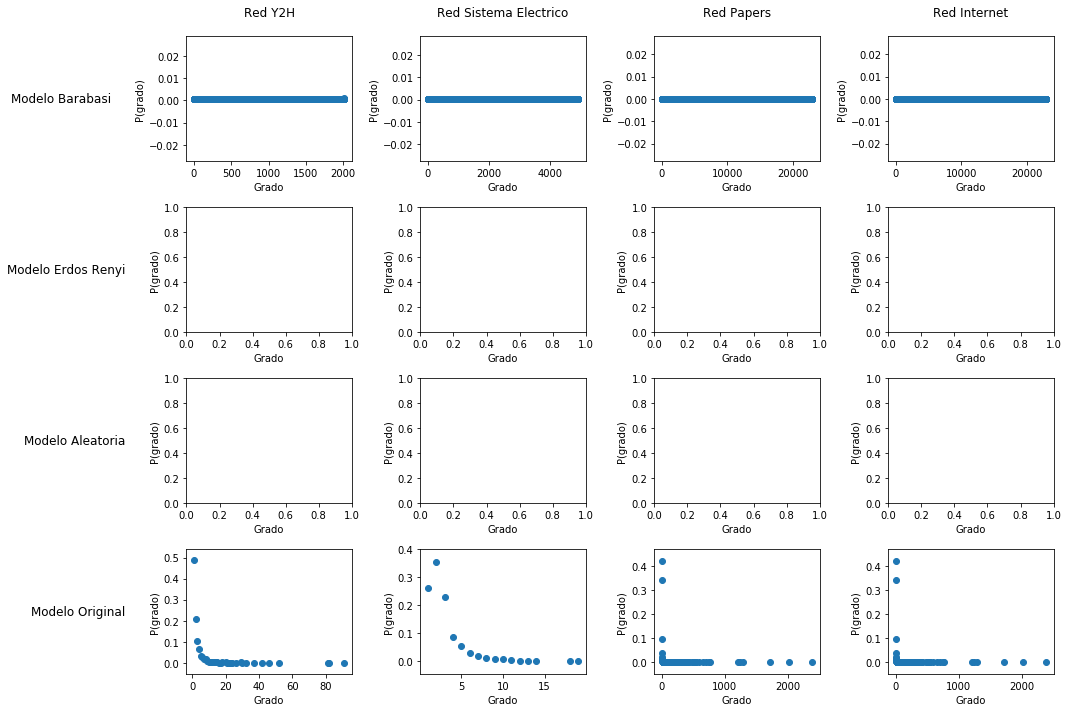

In [29]:
fig, axes = plt.subplots(nrows = 4,ncols = len(Grafo_dict), figsize=(15, 10))
plt.setp(axes.flat, xlabel='Grado', ylabel='P(grado)')
cols = [f'Red {red}' for red in Grafo_dict]
rows = ['Modelo {}'.format(row) for row in ['Barabasi', 'Erdos Renyi', 'Aleatoria', 'Original']]

pad = 20
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

for i,red in enumerate(Grafo_dict):
    x0,y0 = distribucion_grado_normal(Grafo_dict[red]['Barabasi'])
    #x1, y1 = distribucion_grado_normal_meli(Grafo_dict[red]['Erdos Reyni'])
    #x2, y2 = distribucion_grado_normal_meli(Grafo_dict[red]['Aleatoria'])
    x3, y3 = distribucion_grado_normal_meli(Grafo_dict[red]['Grafo'])
    axes[0,i].scatter(x0,y0)
    #axes[1,i].scatter(x1,y1)
    #axes[2,i].scatter(x2,y2)
    axes[3,i].scatter(x3,y3)

plt.tight_layout()
    
    

# 3 (opcional)

In [2]:
"Esta funcion es la misma que el 2C, pero ahora guarda la informacion de los nodos agregados en el paso 5 y el paso 95"

def barabasi_mod(m, final_nodes):
    #m es el grado de los nodos iniciales y a la vez la cantidad de enlaces que agrego por iteracion
    
    node_5 = []
    node_95 = []
    new_node = m + 1 
        
    G = nx.complete_graph(m)
    G_dict = {key: m-1 for key in range(m)}
    
    for step in range(final_nodes - m):
        nodes_to_add = add_edges_mod(G_dict, m)      
        G.add_node(new_node)
        G_dict[new_node] = m
        
         
        for node in nodes_to_add:
            G.add_edge(new_node, node)
            G_dict[node] += 1
        
                
        if G_dict.get(m + 5):
            degree_5 = G_dict[m + 5]
            node_5.append(degree_5)
        
            
        if G_dict.get(m + 95):
            degree_95 = G_dict[m + 95]
            node_95.append(degree_95)
        
        

        new_node += 1
        
    return G,node_5, node_95


        
def add_edges_mod(G_dict, m):
    nodes_probs = []
    nodes = list(G_dict.keys())
    total_degree = sum(G_dict.values())
    
    for node in nodes:
        node_degr = G_dict[node]
        node_prob = node_degr / total_degree
        nodes_probs.append(node_prob)
        
    random_nodes = np.random.choice(nodes, size = m, p = nodes_probs)
    
         
    return random_nodes
    

In [3]:
k_0 = 7
n = 10000
Network_3, grado_5, grado_95 = barabasi_mod(k_0,n)

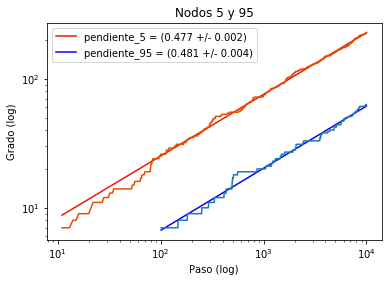

In [21]:
x_5 = list(range(k_0 -1 + 5, n))
x_5_log = np.log(x_5)
y_5 = grado_5
y_5_log = np.log(y_5)

values_5, cov_5 = np.polyfit(x_5_log, y_5_log, 1, cov = True)
lineal_5 = np.poly1d(values_5)
error_5 = np.sqrt(cov_5[1][1])
yfit_5 = lambda x: np.exp(lineal_5(np.log(x)))

plt.loglog(x_5, yfit_5(x_5), label= f'pendiente_5 = ({np.round(lineal_5[1],3)} +/- {np.round(error_5, 3)})',c=(0.9,0.1,0))
plt.loglog(x_5, y_5 , c=(0.9,0.3,0))

x_95 = list(range(k_0 -1 + 95, n))
x_95_log = np.log(x_95)
y_95 = grado_95
y_95_log = np.log(y_95)

values_95, cov_95 = np.polyfit(x_95_log, y_95_log, 1, cov=True)
error_95 = np.sqrt(cov_95[1][1])
lineal_95 = np.poly1d(values_95)
yfit_95 = lambda x: np.exp(lineal_95(np.log(x)))

plt.loglog(x_95, yfit_95(x_95), c='b', label= f'pendiente_95 = ({np.round(lineal_95[1],3)} +/- {np.round(error_95, 3)})')
plt.loglog(x_95, y_95)
plt.xlabel("Paso (log)")
plt.ylabel("Grado (log)")
plt.title("Nodos 5 y 95")
plt.legend()
plt.show()

El grado de cada nodo aumenta siguiendo una ley de potencias con el mismo exponente. Este pendiente es menor a $1$, cada nodo que se agrega tiene más nodos para "elegir", es decir hay más nodos que "compiten" por aumentar su grado. A su vez, los nodos agregados antes tienen mayor grado (por ende, más ventaja a la hora de conseguir nuevos enlaces). 